# Четвертое практичское задание. Анализ временного ряда
## Чиркова Надежда

__Данные:__ [Carbon dioxide emissions from energy consumption](https://datamarket.com/data/set/1x38/environment-carbon-dioxide-emissions-from-energy-consumption-by-source#!ds=1x38!1zrc=e&display=line)

Известны ежемесячные показатели выбросов $CO_2$ из разных источников (сжигание керосина, сжиженного газа, бензина, реактивного топлива и т. д.) с 1973 до 2013 года. Анализируется ряд суммарных выбросов по всем источникам. Требуется сделать прогноз на ближайшие 3 года.

### Считывание данных

In [1]:
data <- read.csv("environment-carbon-dioxide-emiss.csv")

### Визуализация и трансформация ряда

In [355]:
library(forecast)
library(tseries)
library(Hmisc)
library(timeSeries)
library("lmtest")

In [6]:
tSeries <- ts(data = data[[2]], start = c(1973, 1), freq = 12)

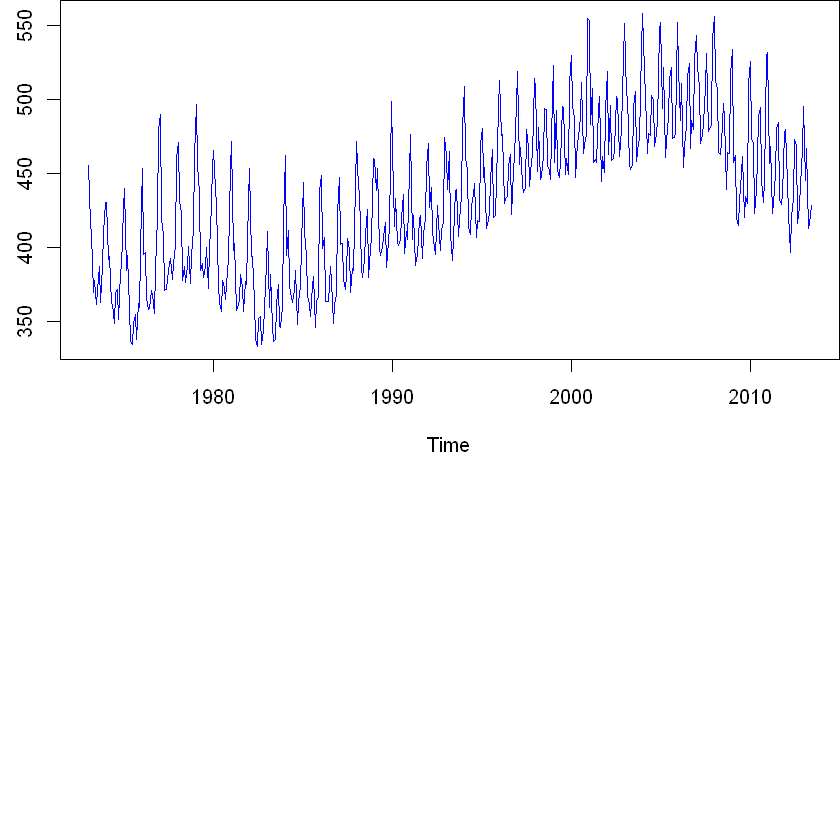

In [7]:
par(pin=c(5, 2), mai=c(4, 0.5, 0, 0))
plot(tSeries, type="l", col="blue")

Преобразование для снятия календарных эффектов:

ERROR: Error in as.POSIXlt.default(time): do not know how to convert 'time' to class "POSIXlt"


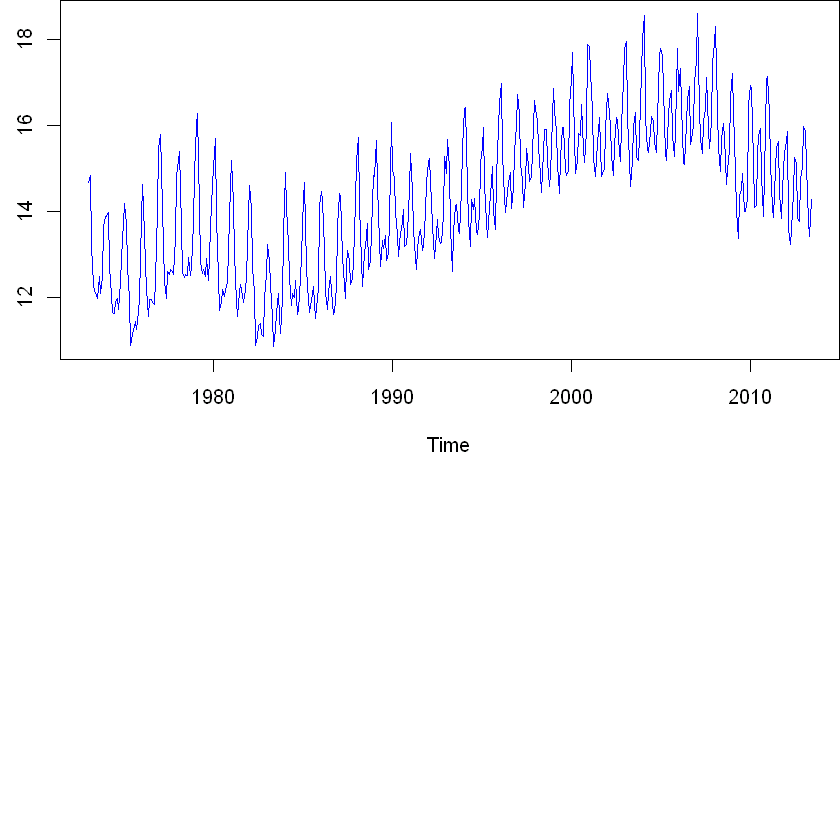

In [11]:
normts <- tSeries / monthDays(time(tSeries))
par(pin=c(5, 2), mai=c(4, 0.5, 0, 0))
plot(normts, type="l", col="blue")

Ряд стал более регулярным, поэтому сохраняем результат преобразования.

Дисперсия всего ряда не меняется с течением времени, поэтому преобразование Бокса-Кокса не требуется. Но ряд является суммой нескольких рядов (выбросы $CO_2$ суммируюся по нескольким источникам), и дисперсия одной из этих составляющих растет. Попробуем все же применить преобразование. 

[1] 1.507104


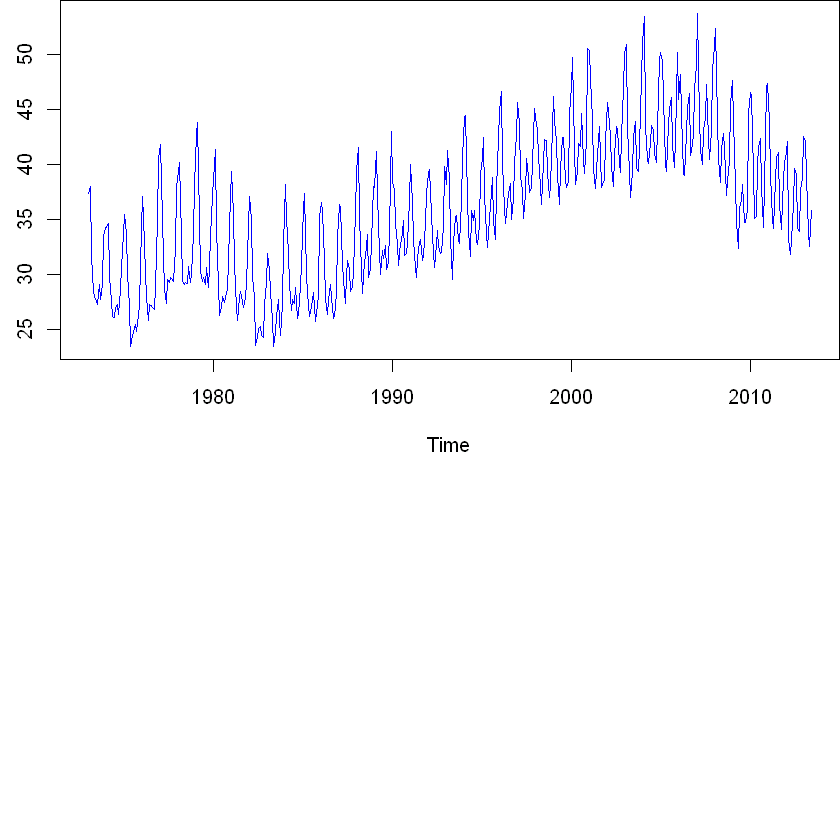

In [17]:
library(forecast)
LambdaOpt <- BoxCox.lambda(normts)
par(pin=c(5, 2), mai=c(4, 0.5, 0, 0))
print(LambdaOpt)
plot(BoxCox(normts, LambdaOpt), type="l", col="blue")

После применения преобразования вид ряда практически не меняется, поэтому не используем его.

Посмотрим на STL-декомпозицию:

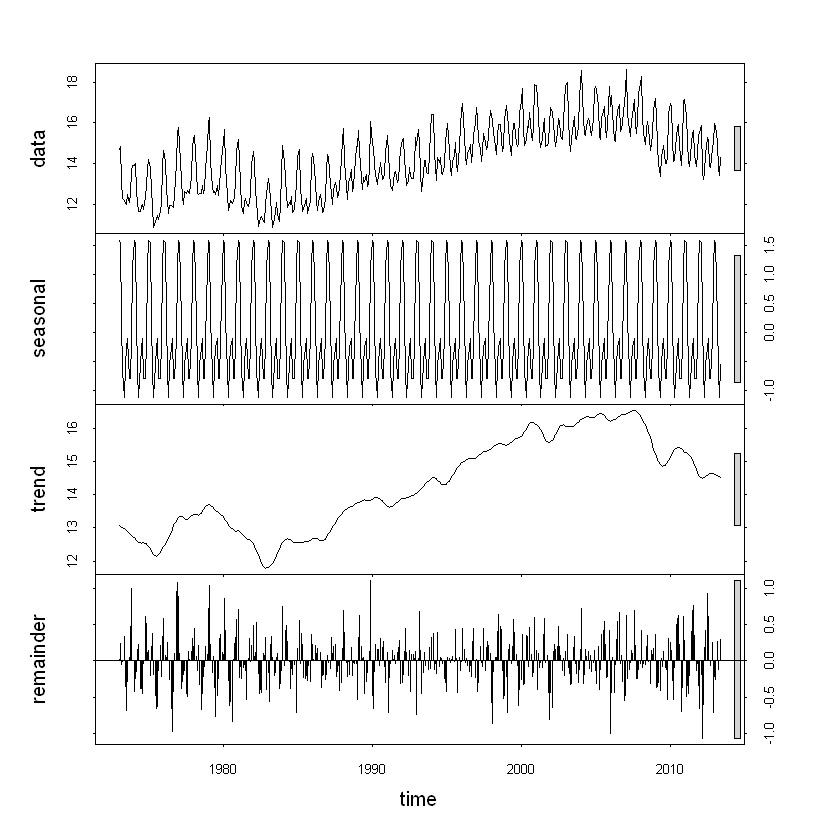

In [98]:
plot(stl(normts, s.window="periodic"))

Выбросов в ряду не видно. Присутствует четко выраженная сезонность, а также тренд, то есть исходный ряд не стационарен. Убедимся в этом с помощью теста KPSS:

In [18]:
kpss.test(normts)$p.value

Warning message:
In kpss.test(normts): p-value smaller than printed p-value

[1] 0.01

Выполним сезонное дифференцирование:

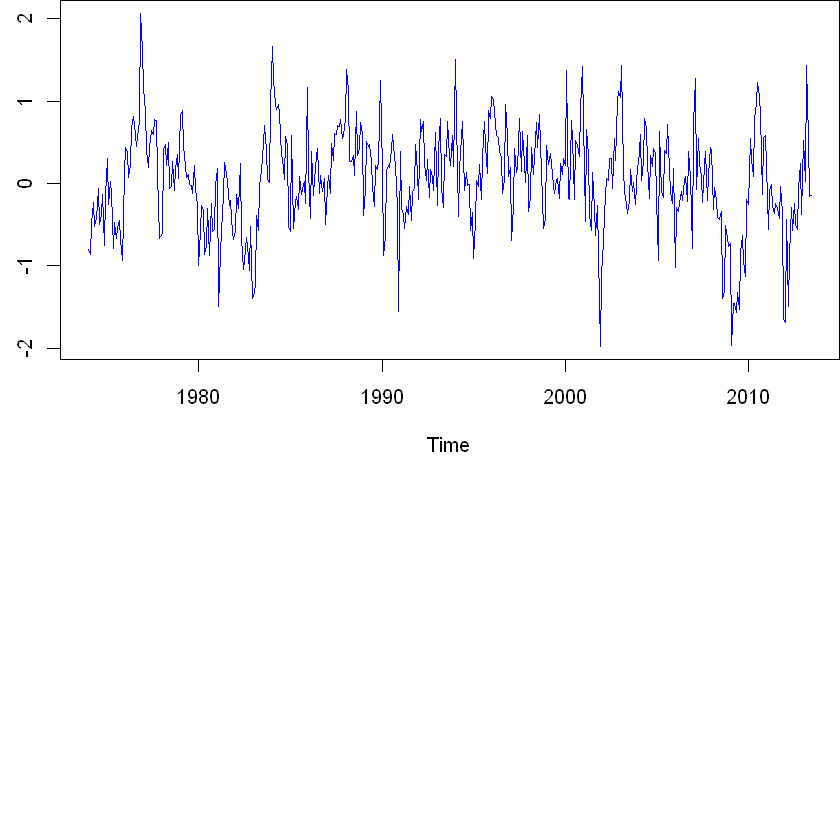

In [311]:
par(pin=c(5, 2), mai=c(4, 0.5, 0, 0))
plot(diff(normts, 12), col="blue")

In [253]:
kpss.test(diff(normts, 12))$p.value

Warning message:
In kpss.test(diff(normts, 12)): p-value greater than printed p-value

[1] 0.1

Ряд выглядит достаточно стационарно, гипотеза стационарности не отвергается, и далее мы будем работать с этим рядом.

In [268]:
finalts <- diff(normts, 12)

### ARIMA

#### Ручной выбор модели

Смотрим на ACF и PACF:

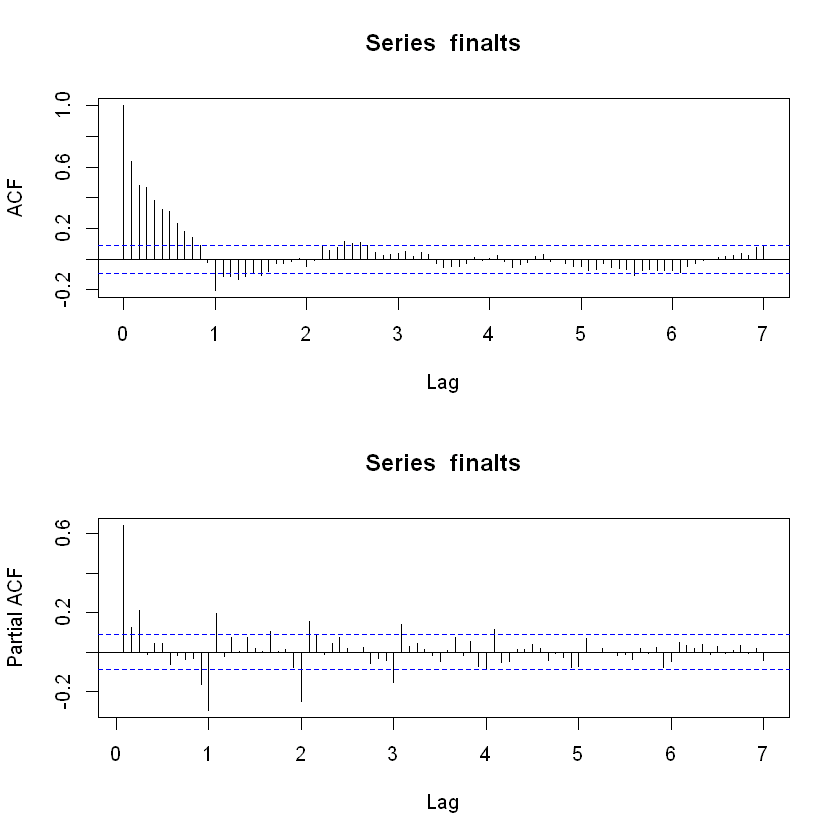

In [270]:
par(mfrow=c(2,1))
acf(finalts, lag.max=12*7)
pacf(finalts, lag.max=12*7)

Нужно выбрать параметры ARIMA(p, d, q)(p', d', q')$_l$, среди которых мы затем будем искать лучшую модель. Учитывая структуру дифференцирования, положим l = 12, d = 0, d' = 1. На ACF значимы лаги $1, \dots, 5$ и 12, q = $1, \dots, 5$, q' = 1, 2. На PACF значимы лаги 1, 12, 13, 24, 25, поэтому p = 1, 2, p' = 1, 2.

In [326]:
arima <- c()
aics <- c()
# а где модели сообщается число 12?
arima <- c(arima, "ARIMA(1, 0, 1)(2, 1, 1)12")
aics <- c(aics, Arima(normts, order=c(1, 0, 1), seasonal=c(2, 1, 1))$aicc)
arima <- c(arima, "ARIMA(1, 0, 2)(2, 1, 1)12")
aics <- c(aics, Arima(normts, order=c(1, 0, 2), seasonal=c(2, 1, 1))$aicc)
arima <- c(arima, "ARIMA(1, 0, 3)(2, 1, 1)12")
aics <- c(aics, Arima(normts, order=c(1, 0, 3), seasonal=c(2, 1, 1))$aicc)
arima <- c(arima, "ARIMA(1, 0, 4)(2, 1, 1)12")
aics <- c(aics, Arima(normts, order=c(1, 0, 4), seasonal=c(2, 1, 1))$aicc)
arima <- c(arima, "ARIMA(1, 0, 5)(2, 1, 1)12")
aics <- c(aics, Arima(normts, order=c(1, 0, 5), seasonal=c(2, 1, 1))$aicc)

# ошибка во время построения модели
#arima <- c(arima, "ARIMA(2, 0, 2)(2, 1, 1)12")
#aics <- c(aics, Arima(normts, order=c(2, 0, 2), seasonal=c(2, 1, 1))$aicc)
arima <- c(arima, "ARIMA(1, 0, 2)(1, 1, 1)12")
aics <- c(aics, Arima(normts, order=c(1, 0, 2), seasonal=c(1, 1, 1))$aicc)
arima <- c(arima, "ARIMA(2, 0, 2)(1, 1, 1)12")
aics <- c(aics, Arima(normts, order=c(2, 0, 2), seasonal=c(1, 1, 1))$aicc)

arima <- c(arima, "ARIMA(1, 0, 2)(2, 1, 2)12")
aics <- c(aics, Arima(normts, order=c(1, 0, 2), seasonal=c(2, 1, 2))$aicc)
# ошибка во время построения модели
#arima <- c(arima, "ARIMA(2, 0, 2)(2, 1, 2)12")
#aics <- c(aics, Arima(normts, order=c(2, 0, 2), seasonal=c(2, 1, 2))$aicc)
arima <- c(arima, "ARIMA(1, 0, 2)(1, 1, 2)12")
aics <- c(aics, Arima(normts, order=c(1, 0, 2), seasonal=c(1, 1, 2))$aicc)
arima <- c(arima, "ARIMA(2, 0, 2)(1, 1, 2)12")
aics <- c(aics, Arima(normts, order=c(2, 0, 2), seasonal=c(1, 1, 2))$aicc)
result <- data.frame(arima, aics)   

In [309]:
result

,arima,aics
1,"ARIMA(1, 0, 1)(2, 1, 1)",433.9399
2,"ARIMA(1, 0, 2)(2, 1, 1)",418.8561
3,"ARIMA(1, 0, 3)(2, 1, 1)",420.8921
4,"ARIMA(1, 0, 4)(2, 1, 1)",419.7483
5,"ARIMA(1, 0, 5)(2, 1, 1)",421.1189
6,"ARIMA(1, 0, 2)(1, 1, 1)",422.2694
7,"ARIMA(2, 0, 2)(1, 1, 1)",424.0333
8,"ARIMA(1, 0, 2)(2, 1, 2)",417.0571
9,"ARIMA(1, 0, 2)(1, 1, 2)",422.2572
10,"ARIMA(2, 0, 2)(1, 1, 2)",424.13


Лучшая модель - ARIMA(1, 0, 2)(2, 1, 2)$_{12}$. Ее остатки (неопределенные первые уже вырезаны):

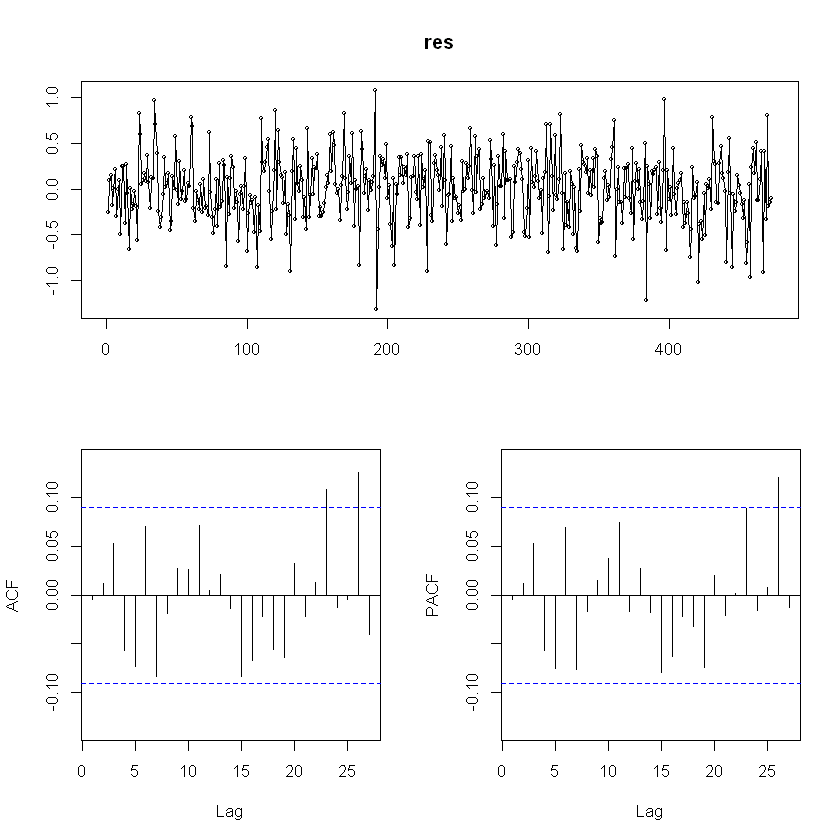

In [378]:
fit <- Arima(normts, order=c(1, 0, 2), seasonal=c(2, 1, 2))
res <- residuals(fit)[-c(1:13)]
tsdisplay(res)

Остаются две автокорреляции и одна частичная автокорреляции остатков, но они имеют большой лаг и не значительно выходят за границы допустимой полосы, поэтому не будем их учитывать.

Достигаемые уровни значимости критерия Льюнга-Бокса для остатков и визуальный анализ остатков:

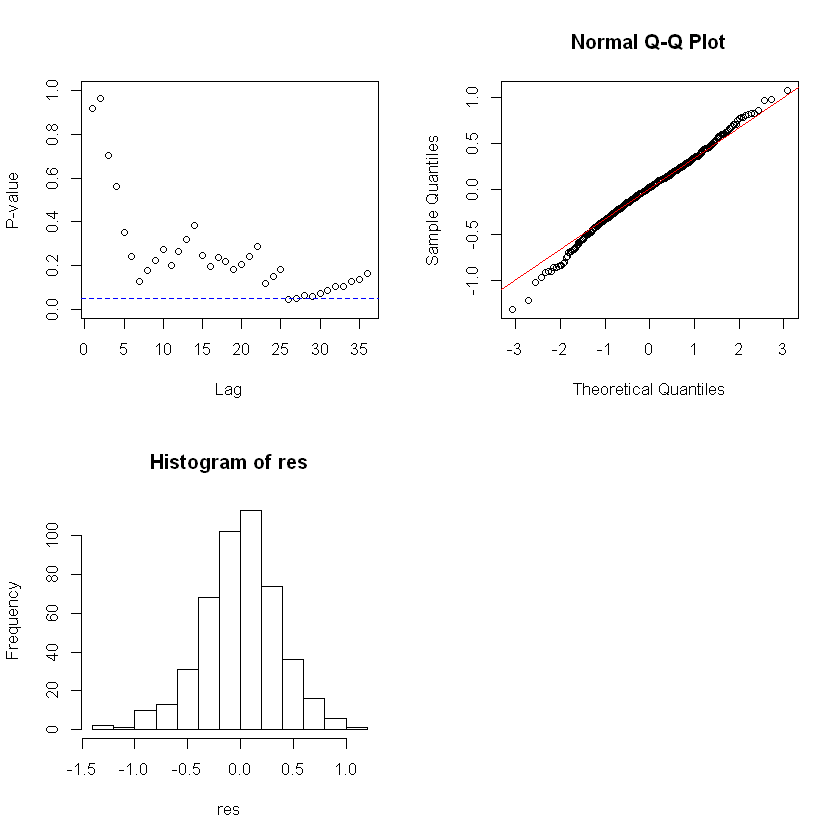

In [379]:
par(mfrow=c(2, 2))
p <- rep(0, 1, frequency(normts)*3)
for (i in 1:length(p)){
  p[i] <- Box.test(res, lag=i, type = "Ljung-Box")$p.value
}
plot(p, xlab="Lag", ylab="P-value", ylim=c(0,1))
abline(h = 0.05, lty = 2, col = "blue")
qqnorm(res)
qqline(res, col="red")
hist(res)

Остатки выглядят нормально. Гипотеза автокоррелированности остатков при больших лагах (тех, которые выходили за границы полосы на коррелограмме) отвергается, но с близким к 0.05 p-value (логично).

Проверим необходимые и желаемые условия на остатки:

In [361]:
cat("Unbiased, Wilcox test:", wilcox.test(res)$p.value, "\n")
cat("Stationarity, KPSS test:", kpss.test(res)$p.value, "\n")
cat("Normality, Shapiro Wilk test:", shapiro.test(res)$p.value, "\n")
cat("Homoscedasticity, Breusch-Pagan test:", bptest(res ~ c(1:length(res)))$p.value)

Unbiased, Wilcox test: 0.569446 


Warning message:
In kpss.test(res): p-value greater than printed p-value

Stationarity, KPSS test: 0.1 
Normality, Shapiro Wilk test: 0.05197779 
Homoscedasticity, Breusch-Pagan test: 0.3017926

Все гипотезы не отвергаются, то есть остатки не смещены, стационарны, нормальны и гомоскедастичны.

#### Автоматический выбор модели

In [365]:
fit.auto <- auto.arima(normts)
fit.auto

Series: normts 
ARIMA(2,1,1)(1,0,0)[12]                    

Coefficients:
         ar1     ar2      ma1    sar1
      0.6045  0.0541  -0.9798  0.8316
s.e.  0.0486  0.0513   0.0122  0.0271

sigma^2 estimated as 0.1986:  log likelihood=-301.04
AIC=612.09   AICc=612.21   BIC=633.01

AICc автоматически подобранной модели значительно выше, чем у модели, подобранной вручную. Проанализируем остатки:

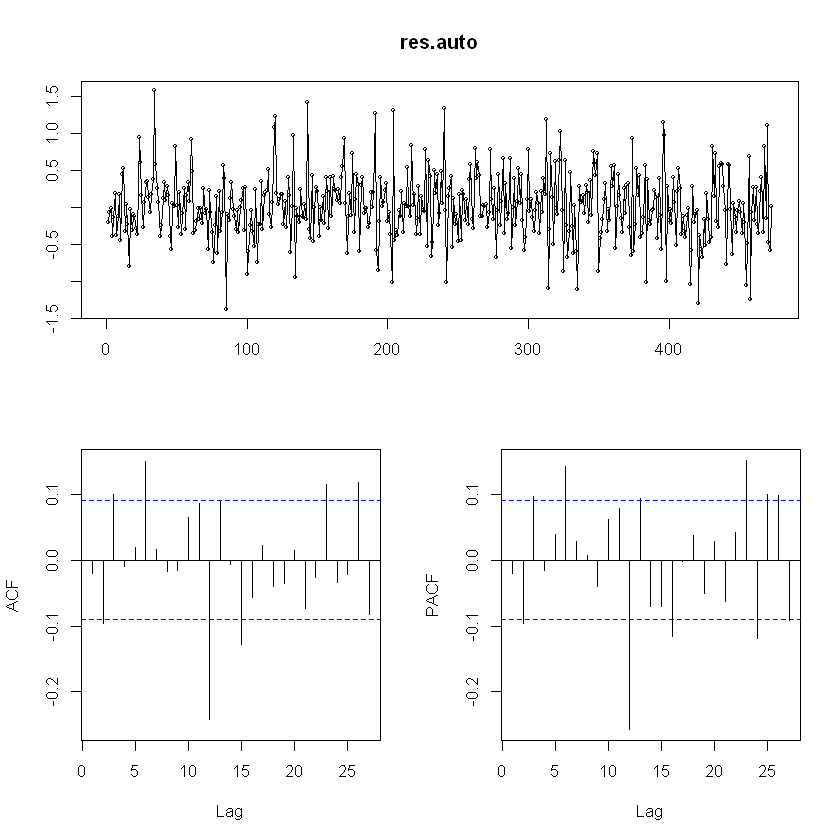

In [367]:
res.auto <- residuals(fit.auto)[-c(1:13)]
tsdisplay(res.auto)

Автокорреляции и частичные автокорреляции значительно чаще выходят за границы полосы, чем у выбранной вручную модели, то есть автоматическая arima предсказывает ряд хуже.

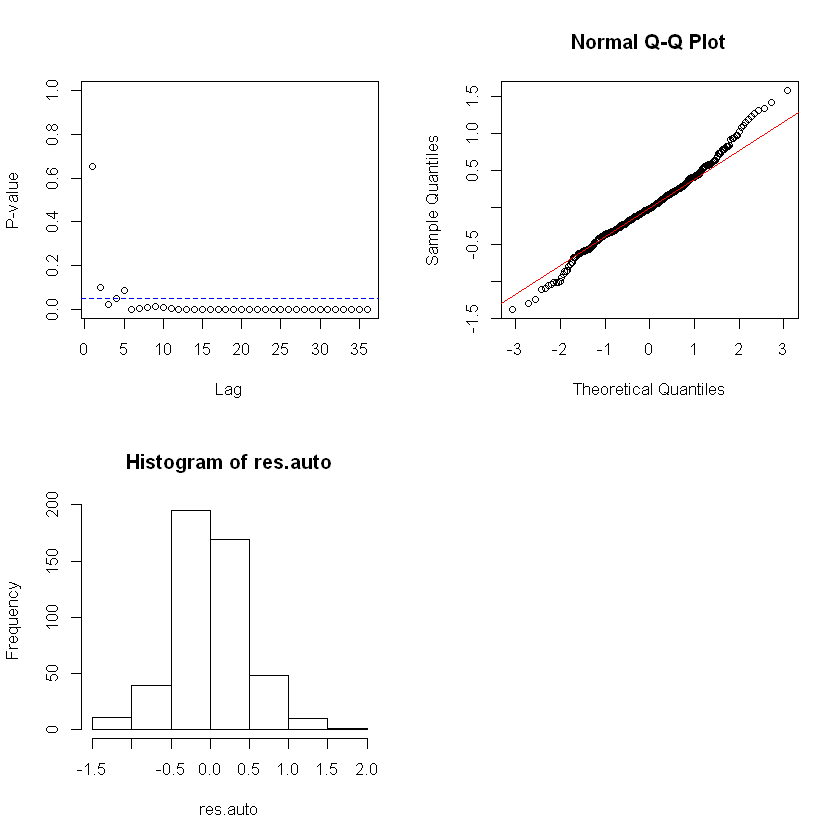

In [368]:
par(mfrow=c(2, 2))
p <- rep(0, 1, frequency(normts)*3)
for (i in 1:length(p)){
  p[i] <- Box.test(res.auto, lag=i, type = "Ljung-Box")$p.value
}
plot(p, xlab="Lag", ylab="P-value", ylim=c(0,1))
abline(h = 0.05, lty = 2, col = "blue")
qqnorm(res.auto)
qqline(res.auto, col="red")
hist(res.auto)

Гипотеза неавтокоррелированности остатков отвергается.

In [369]:
cat("Unbiased, Wilcox test:", wilcox.test(res.auto)$p.value, "\n")
cat("Stationarity, KPSS test:", kpss.test(res.auto)$p.value, "\n")
cat("Normality, Shapiro Wilk test:", shapiro.test(res.auto)$p.value, "\n")
cat("Homoscedasticity, Breusch-Pagan test:", bptest(res.auto ~ c(1:length(res.auto)))$p.value)

Unbiased, Wilcox test: 0.9437128 


Warning message:
In kpss.test(res.auto): p-value greater than printed p-value

Stationarity, KPSS test: 0.1 
Normality, Shapiro Wilk test: 0.0008579051 
Homoscedasticity, Breusch-Pagan test: 0.08632211

Остатки не смещены и стационарны (необходимые условия выполнены), но не нормальны и гетероскедастичны (желаемые условия не выполнены).

По всем показателям автоматически построенная модель проигрывает модели, построенной вручную, поэтому выбираем последнюю.

### Модель экспоненциального сглаживания

In [395]:
fit.ets <- ets(normts)
fit.ets

ETS(M,N,A) 

Call:
 ets(y = normts) 

  Smoothing parameters:
    alpha = 0.3793 
    gamma = 0.1826 

  Initial states:
    l = 13.1272 
    s=1.4577 0.0406 -0.8246 -1.0266 -0.5959 -0.7555
           -0.7599 -1.0689 -0.4775 0.3483 1.8427 1.8197

  sigma:  0.0269

     AIC     AICc      BIC 
2096.484 2097.375 2155.091 

Выбрана модель с мультипликативной ошибкой, без тренда и с аддитивной сезонностью, что в целом логично, так как линейного тренда у ряда нет. Вопрос может вызывать только мультипликативная ошибка (так как дисперсия ряда в целом постоянна), поэтому попробуем построить модель с аддитивной ошибкой:

In [394]:
fit.ets1 <- ets(normts, "AZZ")
fit.ets1

ETS(A,N,A) 

Call:
 ets(y = normts, model = "AZZ") 

  Smoothing parameters:
    alpha = 0.3857 
    gamma = 0.2066 

  Initial states:
    l = 12.8138 
    s=1.562 0.3389 -0.6956 -1.1162 -0.7064 -0.8705
           -0.9812 -1.075 -0.5098 0.3434 1.7347 1.9756

  sigma:  0.3869

     AIC     AICc      BIC 
2111.379 2112.271 2169.986 

Компоненты сезонности и тренда моделируются так же, AICc увеличился, поэтому считаем, что автоматическая модель соответствует особенностям ряда.

Анализ остатков:

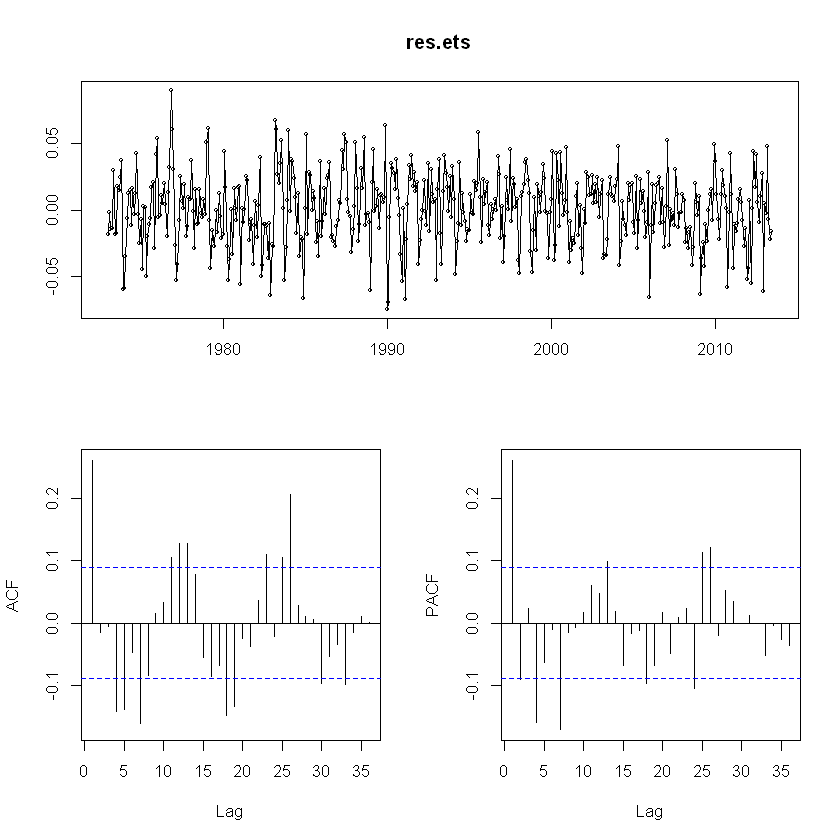

In [396]:
res.ets <- residuals(fit.ets)
tsdisplay(res.ets)

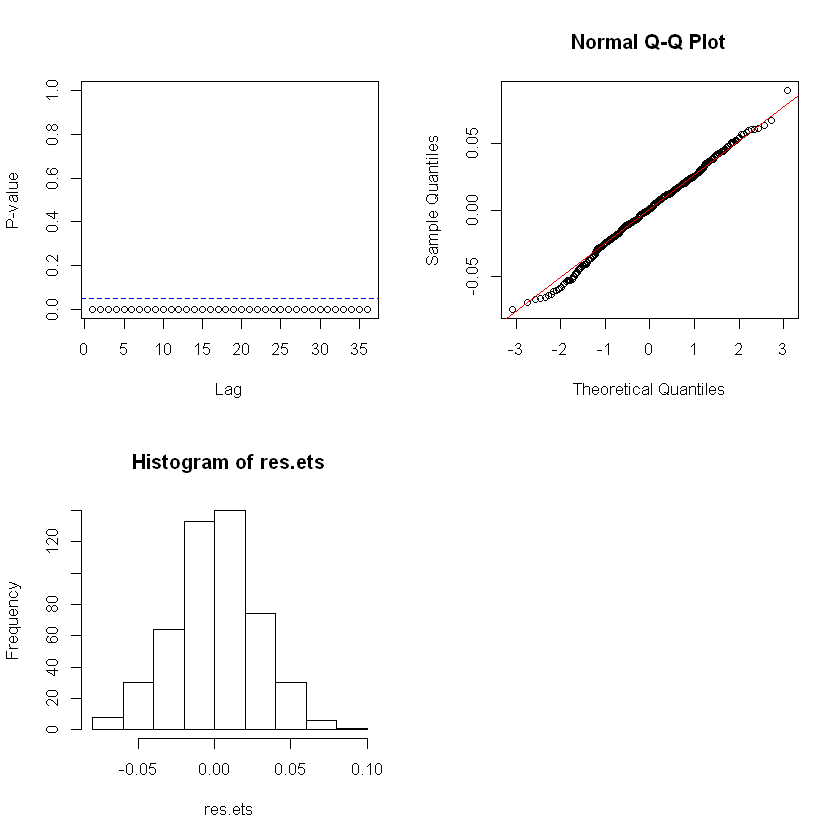

In [397]:
par(mfrow=c(2, 2))
p <- rep(0, 1, frequency(normts)*3)
for (i in 1:length(p)){
  p[i] <- Box.test(res.ets, lag=i, type = "Ljung-Box")$p.value
}
plot(p, xlab="Lag", ylab="P-value", ylim=c(0,1))
abline(h = 0.05, lty = 2, col = "blue")
qqnorm(res.ets)
qqline(res.ets, col="red")
hist(res.ets)

Остатки автокоррелированы (тест Льюнга-Бокса это подтверждает, отвергая гипотезу неавтокоррелированности), то есть модель нельзя считать хорошей. Остатки, по всей видимости, нормальны.

In [398]:
cat("Unbiased, Wilcox test:", wilcox.test(res.ets)$p.value, "\n")
cat("Stationarity, KPSS test:", kpss.test(res.ets)$p.value, "\n")
cat("Normality, Shapiro Wilk test:", shapiro.test(res.ets)$p.value, "\n")
cat("Homoscedasticity, Breusch-Pagan test:", bptest(res.ets ~ c(1:length(res.ets)))$p.value)

Unbiased, Wilcox test: 0.3102786 


Warning message:
In kpss.test(res.ets): p-value greater than printed p-value

Stationarity, KPSS test: 0.1 
Normality, Shapiro Wilk test: 0.3511083 
Homoscedasticity, Breusch-Pagan test: 0.0615458

Все гипотезы не отвергаются, можно строить доверительные интервалы.

### Анализ струтурных изменений ряда

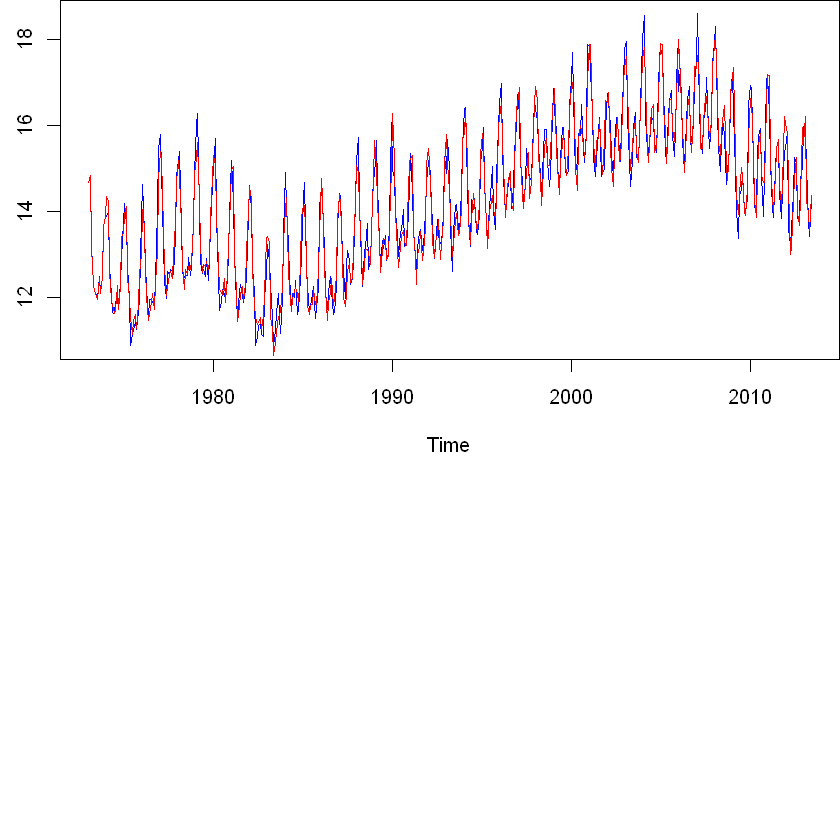

In [413]:
# Визуализируем исходный ряд и предсказания ARIMA
par(pin=c(5, 2), mai=c(4, 0.5, 0, 0))
plot(normts, col="blue")
lines(fitted(fit), col="red")

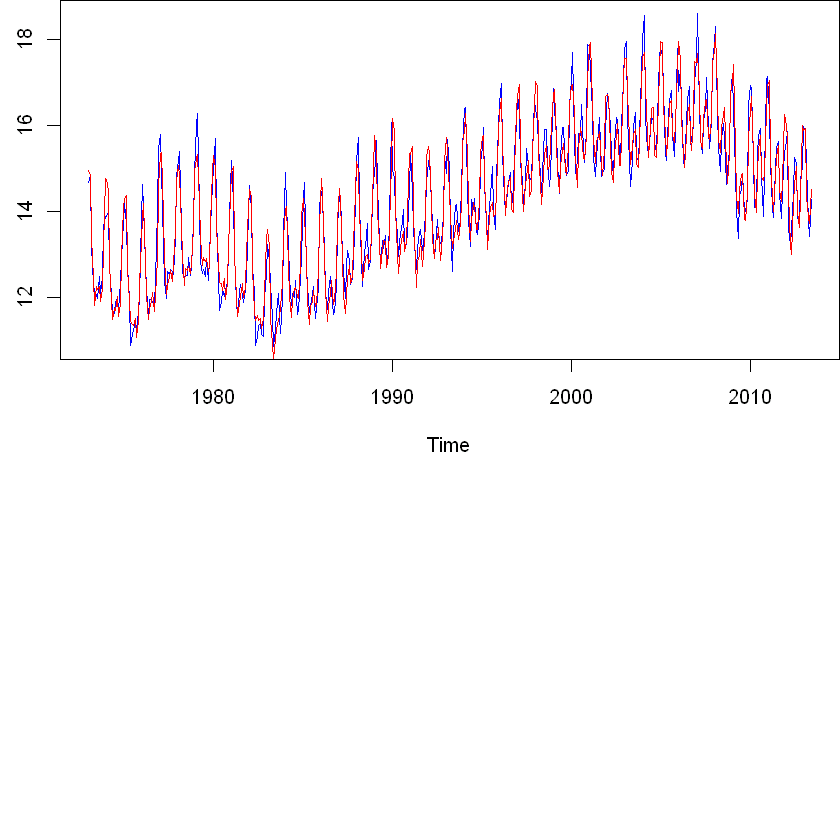

In [442]:
# Визуализируем исходный ряд и предсказания ETS
par(pin=c(5, 2), mai=c(4, 0.5, 0, 0))
plot(normts, col="blue")
lines(fit.ets$fitted, col="red")

В целом обе модели успевают реагировать на изменение тренда, поэтому структурных изменений в модели учитывать не нужно. Но сам ряд имеет некоторый излом около 2008 года. Попробуем формально проверить критерий Чоу для ETS:

In [554]:
n <- length(normts)
m <- ets(normts)
k <- length(m$par)
rss <- sum(m$residuals^2)
m1 <- ets(normts[1:420])
k1 <- length(m1$par)
rss1 <- sum(m1$residuals^2)
m2 <- ets(normts[420:n])
k2 <- length(m2$par)
rss2 <- sum(m2$residuals^2)
f <- ((rss-rss1-rss2)/(k1+k2-k)) / ((rss1-rss2)/(n-k1-k2))
pf(f, k1+k2-k, n-k1-k2)

Warning message:
In pf(f, k1 + k2 - k, n - k1 - k2): созданы NaN

[1] NaN

In [555]:
c(k1, k2, k)

[1]  2  2 14

Статистику посчитать нельзя, потому что k1+k2-k < 0...

Критерий Чоу для Arima:

In [493]:
n <- length(normts)
m <- Arima(normts, order=c(1, 0, 2), seasonal=c(2, 1, 2))
k <- length(m$coef)
rss <- sum(m$residuals^2)
m1 <- Arima(normts[1:420], order=c(1, 0, 2), seasonal=c(2, 1, 2))
k1 <- length(m1$coef)
rss1 <- sum(m1$residuals^2)
m2 <- Arima(normts[420:n], order=c(1, 0, 2), seasonal=c(2, 1, 2))
k2 <- length(m2$coef)
rss2 <- sum(m2$residuals^2)
f <- ((rss-rss1-rss2)/(k1+k2-k)) / ((rss1-rss2)/(n-k1-k2))
pf(f, k1+k2-k, n-k1-k2)

[1] 0

Критерий Чоу отклоняет гипотезу стабильности модели и говорит, что в модели есть структурное изменение. Визуализируем исходный ряд и модель, составленную из двух участков:

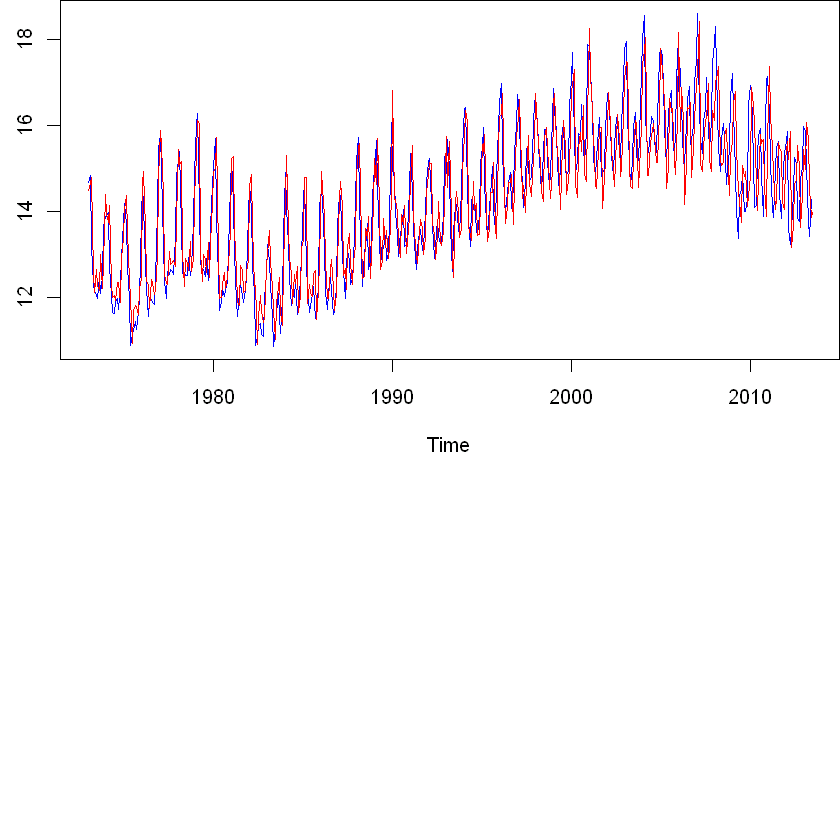

In [486]:
par(pin=c(5, 2), mai=c(4, 0.5, 0, 0))
plot(normts, col="blue")
lines(ts(c(fitted(m1), fitted(m2)), start = c(1973, 1), freq = 12), col="red", type='l')

Очевидно, что такая модель хуже обычной ARIMA: первый участок начинает необоснованно идти сниз, а предсказания второго опаздывают. Поэтому считаем, что структурные изменения в модели не нужны. 

### Сравнение моделей

Сравним Arima, настроенную вручную, и ETS. Сначала посмотрим на качество предсказания на тестовом участке:

In [495]:
train <- window(normts, end=c(2009, 12))
test <- window(normts, start=c(2010, 1))
D <- length(test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.01280367,0.38324106,0.29913661,0.05503802,2.09955610,0.64243260,0.23357737,NA
Test set,0.007308988,0.527909035,0.434472604,-0.065769400,2.881169811,0.933083267,0.613121502,0.566618010


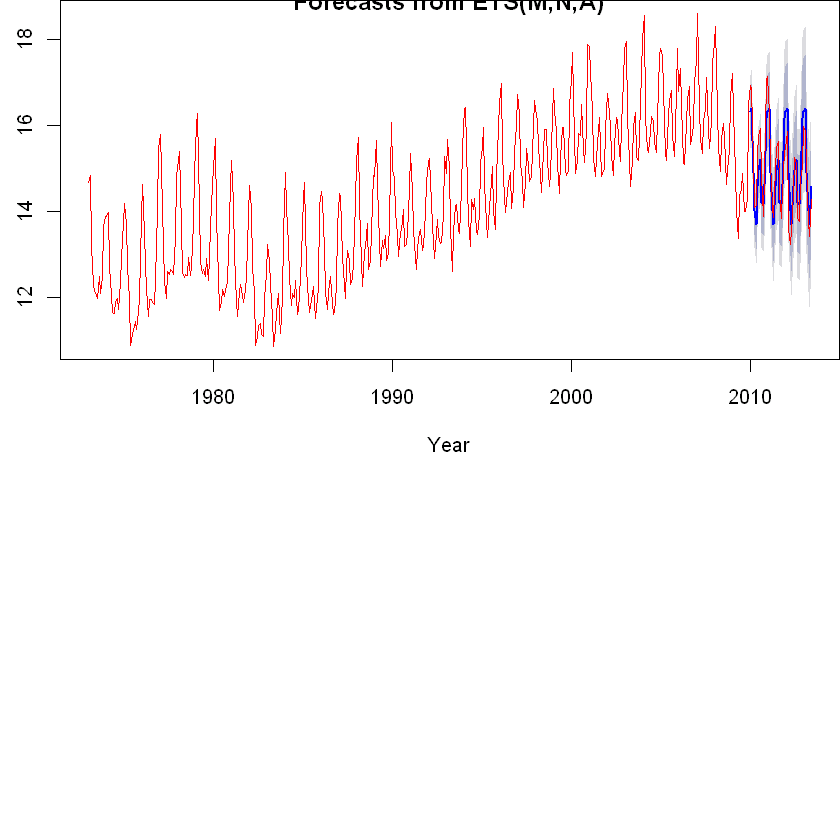

In [511]:
par(pin=c(5, 2), mai=c(4, 0.5, 0, 0))
fitShort.ets <- ets(train, model="MNA")
fc       <- forecast(fitShort.ets, h=D)
accuracy(fc, test)
plot(forecast(fitShort.ets, h=D), xlab="Year")
lines(normts, col="red")

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.01146380,0.35383304,0.27110158,0.03596840,1.89736205,0.58222393,-0.00648576,NA
Test set,-0.2430422,0.6537155,0.5353925,-1.7581641,3.6006091,1.1498212,0.7276081,0.7175439


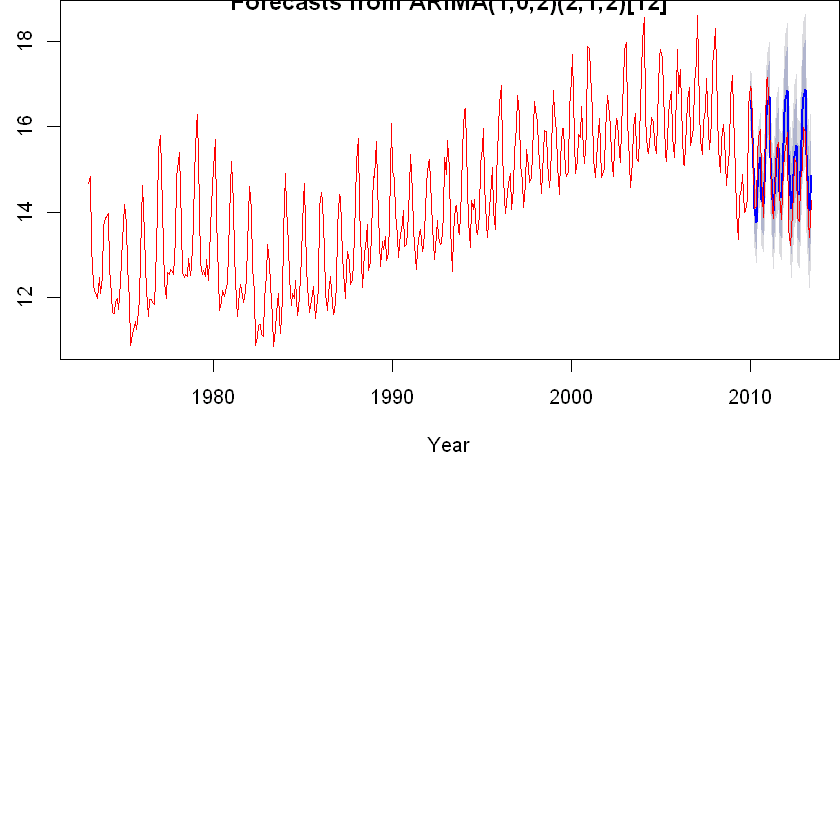

In [512]:
par(pin=c(5, 2), mai=c(4, 0.5, 0, 0))
fitShort.arima <- Arima(train, order=c(1, 0, 2), seasonal=c(2, 1, 2))
fc       <- forecast(fitShort.arima, h=D)
accuracy(fc, test)
plot(forecast(fitShort.arima, h=D), xlab="Year")
lines(normts, col="red")

По всем критериям ARIMA лучше на обучающем участке, но хуже на тестовом. С учетом изменения тренда в последние годы, которое мы анализировали в предыдущем пункте, можно сказать, что ETS быстрее настраивается на изменение динамики ряда, чем ARIMA. Это видно и по графикам: прогноз Arima имеет растущий тренд, потому что он присутствовал на предыдущем участке ряда, хотя в данных его уже нет.

Визуализируем остатки:

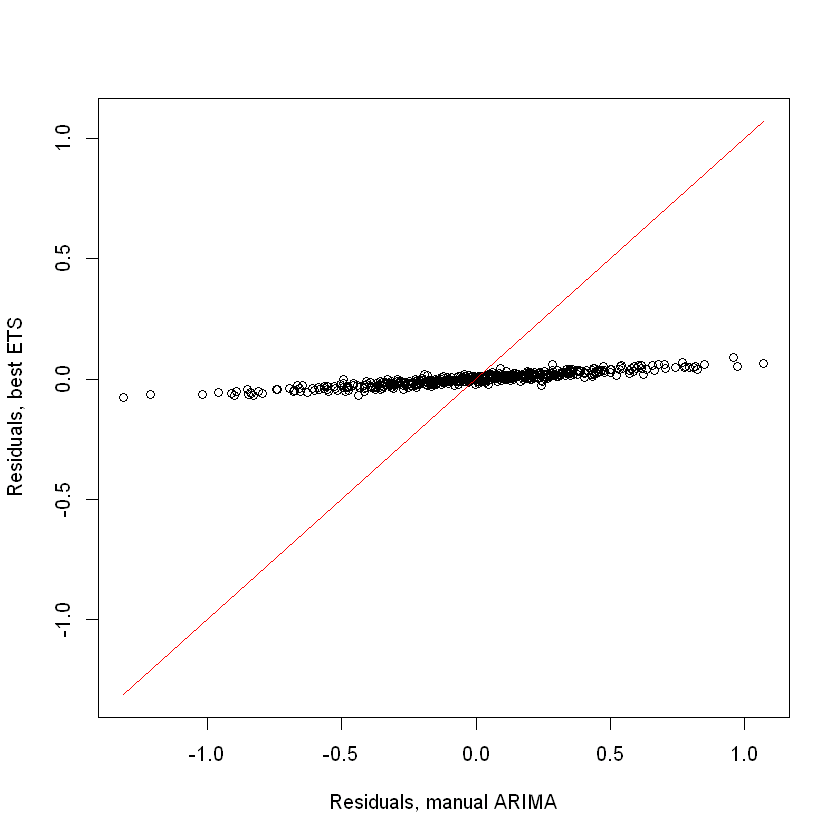

In [520]:
plot(res, res.ets[-c(1:13)], 
     xlab="Residuals, manual ARIMA",
     ylab="Residuals, ETS",
     xlim=c(min(c(res, res.ets), na.rm=T), max(c(res, res.ets), na.rm=T)),
     ylim=c(min(c(res, res.ets), na.rm=T), max(c(res, res.ets), na.rm=T)))
 lines(c(min(c(res, res.ets), na.rm=T), max(c(res, res.ets), na.rm=T)), c(min(c(res, res.ets), na.rm=T), 
                                                                          max(c(res, res.ets), na.rm=T)), col="red")

In [524]:
sd(res.ets)
sd(res)

[1] 0.02690946

[1] 0.3629111

Разброс остатков Arima значительно выше, чем у ETS, и пронозы ETS визуально точнее. Сравним по критерию Диболда-Мариано с соответствующей односторонней альтернативой:

In [527]:
dm.test(res, res.ets, alternative = "greater")

Warning message:
In c(abs(e1))^power - c(abs(e2))^power: длина большего объекта не является произведением длины меньшего объекта


	Diebold-Mariano Test

data:  resres.ets
DM = 13.671, Forecast horizon = 1, Loss function power = 2, p-value <
2.2e-16
alternative hypothesis: greater


Нулевая гипотеза уверенно отвергается. ETS выиграл :)

##### Финальный прогноз

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jul 2013       14.85470 14.34266 15.36673 14.07161 15.63778
Aug 2013       14.92158 14.37177 15.47138 14.08073 15.76243
Sep 2013       13.79341 13.24398 14.34284 12.95313 14.63370
Oct 2013       13.53949 12.96837 14.11061 12.66603 14.41294
Nov 2013       14.25088 13.63360 14.86816 13.30683 15.19492
Dec 2013       15.50289 14.82462 16.18115 14.46557 16.54020
Jan 2014       15.94874 15.22913 16.66834 14.84820 17.04927
Feb 2014       15.93432 15.18545 16.68319 14.78902 17.07962
Mar 2014       14.50237 13.75908 15.24565 13.36561 15.63912
Apr 2014       13.60439 12.85707 14.35171 12.46146 14.74732
May 2014       13.45907 12.66498 14.25316 12.24461 14.67353
Jun 2014       14.37410 13.54207 15.20613 13.10162 15.64659
Jul 2014       14.85470 13.99578 15.71361 13.54110 16.16830
Aug 2014       14.92158 14.04040 15.80276 13.57393 16.26923
Sep 2014       13.79341 12.91014 14.67668 12.44257 15.14426
Oct 2014       13.53949 12.63830 14.4406

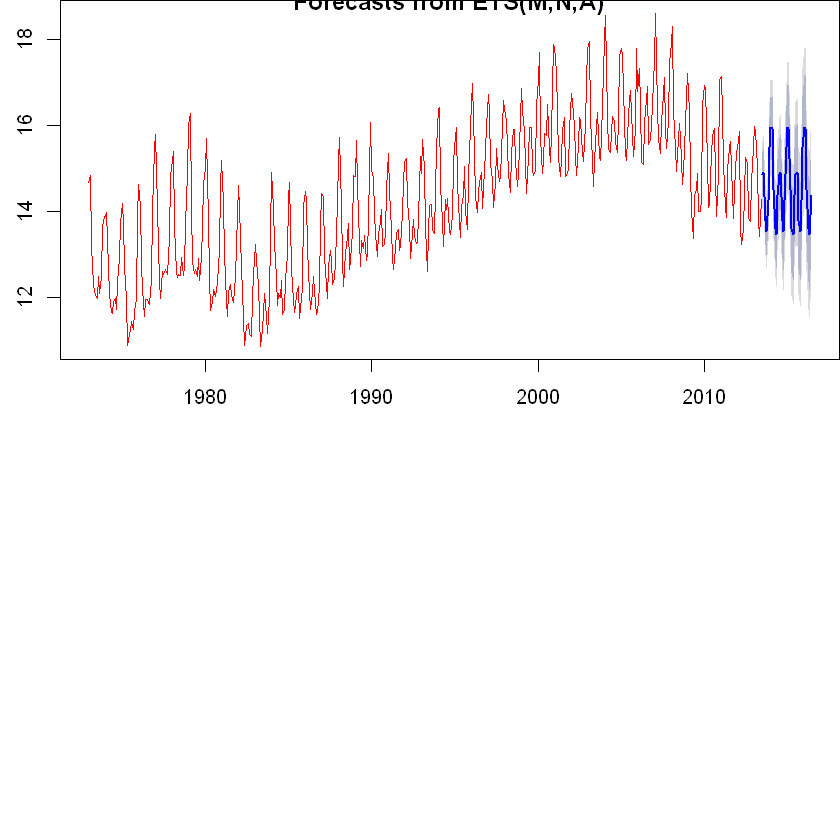

In [558]:
par(pin=c(8, 4), mai=c(4, 0.5, 0, 0))
fl <- forecast(fit.ets, h=12*3)
print(fl)
plot(fl, col="red")

ETS прогнозирует постоянные (за вычетом сезонности) величины выбросов CO$_2$ от источников энергии.

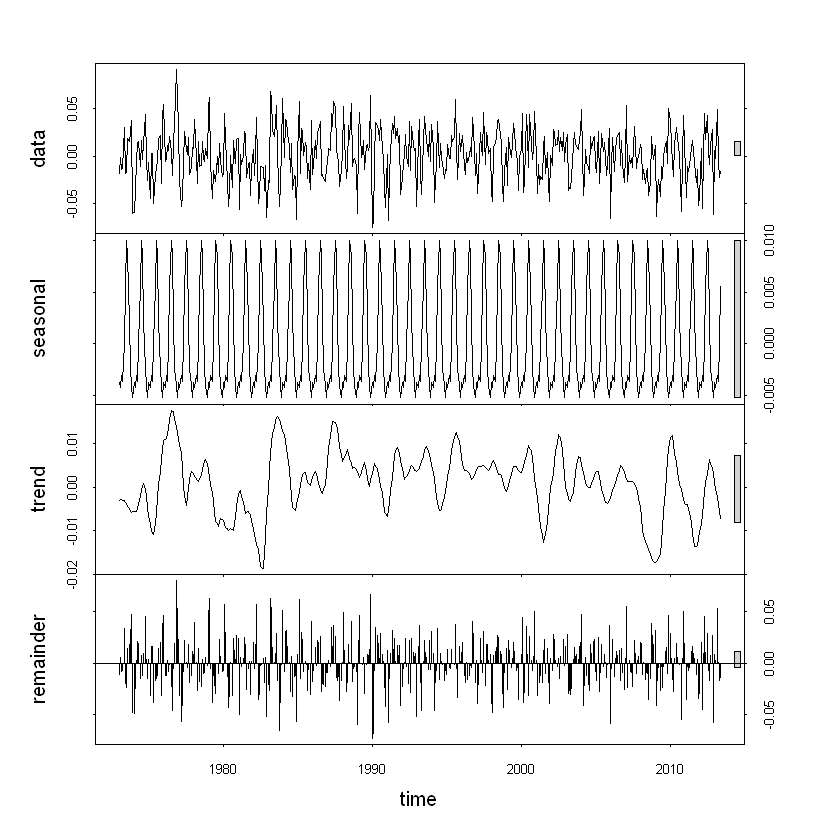

In [540]:
# Для выводов:
plot(stl(res.ets, s.window="periodic"))

### Выводы для математиков
В задании попробованы два подхода к прогнозированию временного ряда: SARIMA и экспоненциальное сглаживание. Более точные предсказания делает модель ETS (по метрикам точности, по критерию Диболда-Мариано и по визуальному анализу остатков): ETS точнее предсказывает величину колебаний (лучше приближает пики, дисперсия остатков значительно меньше, чем у ARIMA) и быстрее адаптируется к изменяющемуся тренду.  

Однако остатки ARIMA менее коррелированы, чем у ETS. Причина этого в том, что ARIMA ориентирована на избавление от автокорреляций (мы выбирали модель с учетом коррелограмм), а ETS учитывает их в меньшей степени.
Еще одно объяснение этого противоречия кроется в структуре ряда, который имеет нетривиальную струтуру сезонности (наложение сезонностей компонент). ETS учитывает основную компоненту сезонности, но не учитывает низкодисперсионную сезонность, и именно она отражается на коррелограмме остатков. Поскольку величины этих колебаний маленькие (видно по масштабу оси seasonal на STL-разложении выше), они слабо влияют на точность прогноза. 

Таким образом, Arima практически идеально моделирует структуру сезонности ряда, но плохо моделирует тренд, а ETS наоборот, учитывает не все компоненты сезонности, но успевает за изменениями тренда, и поэтому точность предсказаний ETS выше.



### Выводы для не-математиков-экспертов в предметной области

* Суммарные показатели выбросов диоксида углерода сильно зависят от времени года и месяца. В итоговой модели первая зависимость прогнозируется хорошо, а вторая хуже, но можно построить более сложную модель, которая учтет и вторую зависимость тоже.
* В течение предыдущих двух десятилетий показатель постоянно линейно рос, но затем упал и продолжает быть стабильным. Поэтому прогноз на ближайшие годы также говорит, что показатель будет в среднем оставаться постоянным.
* Имея данные за предыдущий год, на следующий год можно сделать весьма точное предсказание.